# McDonalds Ice Cream Machines Breaking - Timeseries

The 'mcdonalds_dataset.csv' contains information on the number of complaints about broken McDonalds over time all over the world.

The data is scraped from [mcbroken](https://mcbroken.com/) and points had been collected every hour.

Note: The longitude and latitude values are swapped in the dataset!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('mcdonalds_dataset.csv')
# change the longitude and latitude names
df = df.rename(columns={'lat': 'longitude', 'lon': 'latitude'})
df.head()

,longitude,latitude,alt,is_broken,is_active,dot,state,city,street,country,last_checked
0,-73.988281,40.718830,0,False,True,working,NY,New York,114 Delancey St,USA,Checked 142 minutes ago
1,-74.005090,40.728794,0,False,True,working,NY,New York,208 Varick St,USA,Checked 142 minutes ago
2,-73.993408,40.729197,0,False,True,working,NY,New York,724 Broadway,USA,Checked 142 minutes ago
3,-73.985855,40.726555,0,False,True,working,NY,New York,102 1st Ave,USA,Checked 142 minutes ago
4,-73.991692,40.691383,0,True,True,broken,NY,Brooklyn,82 Court St,USA,Checked 142 minutes ago


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16671 entries, 0 to 16670
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   longitude     16671 non-null  float64
 1   latitude      16671 non-null  float64
 2   alt           16671 non-null  int64  
 3   is_broken     16671 non-null  bool   
 4   is_active     16671 non-null  bool   
 5   dot           16671 non-null  object 
 6   state         12725 non-null  object 
 7   city          16663 non-null  object 
 8   street        16671 non-null  object 
 9   country       16671 non-null  object 
 10  last_checked  16671 non-null  object 
dtypes: bool(2), float64(2), int64(1), object(6)
memory usage: 1.2+ MB


Let's do some exploratory data analysis!

First, let's constrain our data analysis to active ice creame machines: 

In [4]:
df = df[df['is_active']]
df.shape

(16352, 11)

It would be fun to see the distribution of active ice cream machines on the earth map. Let's do it:

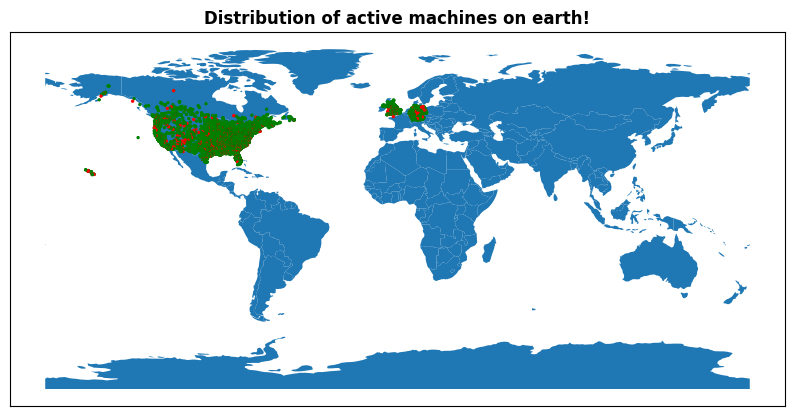

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)   

file_path = './110m_cultural/'
world = gpd.read_file(file_path)

color = ['red' if machine['is_broken'] else 'green' for _, machine in df.iterrows()]
ax = gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color=color, markersize=2)
# remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# add title
ax.set_title('Distribution of active machines on earth!', fontweight='bold')
plt.show()

Let's see which country has the most broken machines:

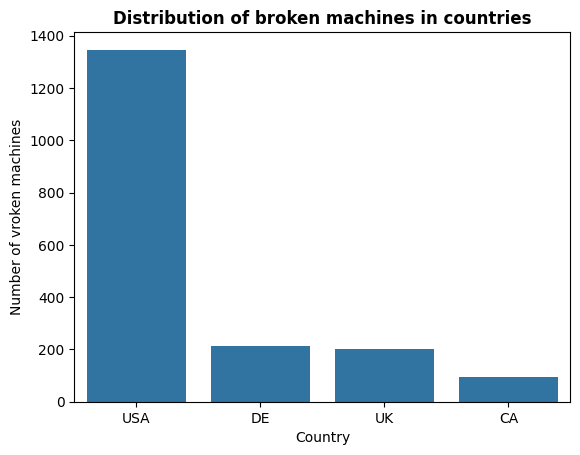

In [6]:
df_country = df.groupby(['country']).sum('is_broken').reset_index().sort_values('is_broken', ascending=False)

plt.figure()
sns.barplot(df_country, x=df_country['country'], y=df_country['is_broken'])

plt.title('Distribution of broken machines in countries', weight='bold')
plt.ylabel('Number of vroken machines')
plt.xlabel('Country');


We can see that United States has the most broken machines (and also the biggest number of machines :)). Now let's see within US, which State has the most broken machines.

From the dataframe information above we can see that there are null values for state. So, it is better to first see whether there are null values for state columns among the data from United States:

In [7]:
df[df['country'] == 'USA']['state'].isnull().sum()

0

Fortunately, there is no null value among the data from United States. So, let's move on by finding the states with the largest number of broken machines!

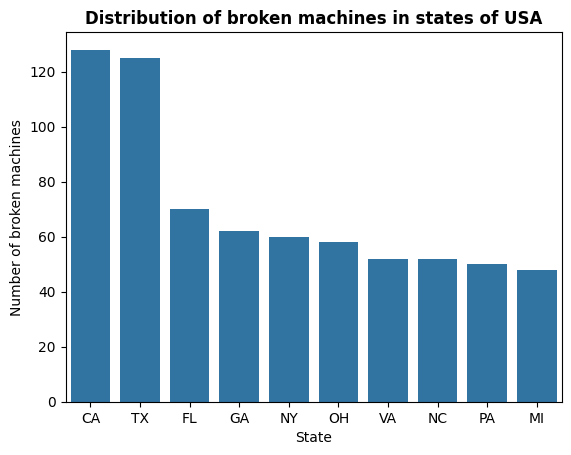

In [8]:
df_state = df[df['country'] == 'USA'].groupby(['state']).sum('is_broken').reset_index().sort_values('is_broken', ascending=False)

# because there are a lot of states, only plot top 10 states
plt.figure()
sns.barplot(df_country, x=df_state['state'].head(10), y=df_state['is_broken'].head(10))

plt.title('Distribution of broken machines in states of USA', fontweight='bold')
plt.ylabel('Number of broken machines')
plt.xlabel('State');

We can see that **California** and **Texas** have the most broken machines, repectively!

Let's find the busiest time for complaints. To do so, I'm going to add a column which shows the last_checked time in terms of minutes ago.

In [9]:
import re

# function to separate number part from a string
def get_minutes(text):
    # Use regular expression to find the number in the string
    number = re.search(r'\d+', text)
    
    if number:
        extracted_number = int(number.group())
        return extracted_number 

In [10]:
# apply the funtion on the dataframe
df['last_checked_minutes_ago'] = df['last_checked'].apply(get_minutes)
df.head()

,longitude,latitude,alt,is_broken,is_active,dot,state,city,street,country,last_checked,last_checked_minutes_ago
0,-73.988281,40.718830,0,False,True,working,NY,New York,114 Delancey St,USA,Checked 142 minutes ago,142
1,-74.005090,40.728794,0,False,True,working,NY,New York,208 Varick St,USA,Checked 142 minutes ago,142
2,-73.993408,40.729197,0,False,True,working,NY,New York,724 Broadway,USA,Checked 142 minutes ago,142
3,-73.985855,40.726555,0,False,True,working,NY,New York,102 1st Ave,USA,Checked 142 minutes ago,142
4,-73.991692,40.691383,0,True,True,broken,NY,Brooklyn,82 Court St,USA,Checked 142 minutes ago,142


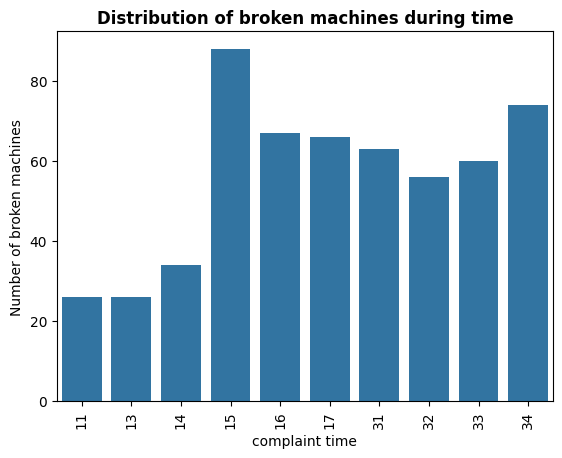

In [11]:
df_time = df.groupby(['last_checked_minutes_ago']).sum('is_broken').reset_index().sort_values('is_broken', ascending=False)
# because there are a lot of times, only plot top 10
plt.figure()
sns.barplot(df_time, x=df_time['last_checked_minutes_ago'].head(10), y=df_time['is_broken'].head(10))

plt.title('Distribution of broken machines during time', fontweight='bold')
plt.ylabel('Number of broken machines')
plt.xlabel('complaint time')
plt.xticks(rotation='vertical');

We can see that **15 minutes** ago has the most number of complaints.